In [ ]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from itertools import combinations


from darts import TimeSeries
from darts.models import ExponentialSmoothing, ARIMA, Prophet, RegressionEnsembleModel
from darts.metrics import mae
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
path = 'C:/Users/natha/OneDrive/Bureau/Interview trainings/Coding/Aquatic/Weather_Forecast_Ideas/data/chicago_beach_weather.csv'
df = pd.read_csv(path)
df.head()

,Station Name,Measurement Timestamp,Air Temperature
0,63rd Street Weather Station,01/01/2016 12:00:00 AM,-2.80
1,Oak Street Weather Station,01/01/2016 12:00:00 AM,-2.30
2,Foster Weather Station,01/01/2016 12:00:00 AM,-3.67
3,63rd Street Weather Station,01/01/2016 01:00:00 AM,-3.40
4,Foster Weather Station,01/01/2016 01:00:00 AM,-4.56


In [5]:
df['Measurement Timestamp'] = pd.to_datetime(df['Measurement Timestamp'], format='%m/%d/%Y %I:%M:%S %p')

In [6]:
stations = df['Station Name'].unique()
station_data = {station: df[df['Station Name'] == station] for station in stations}

In [7]:
# Handle missing dates and fill missing values
for station, data in station_data.items():
    data.set_index('Measurement Timestamp', inplace=True)
    data = data.asfreq('H')  # Assuming hourly frequency
    data['Air Temperature'].fillna(method='ffill', inplace=True)  # Forward fill missing values
    station_data[station] = data

In [8]:
# Create a Darts TimeSeries object for each station
time_series_data = {}
for station, data in station_data.items():
    time_series_data[station] = TimeSeries.from_dataframe(data, value_cols='Air Temperature', fill_missing_dates=True, freq='H')

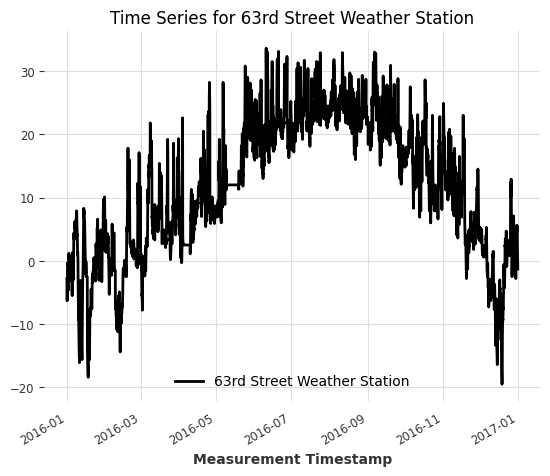

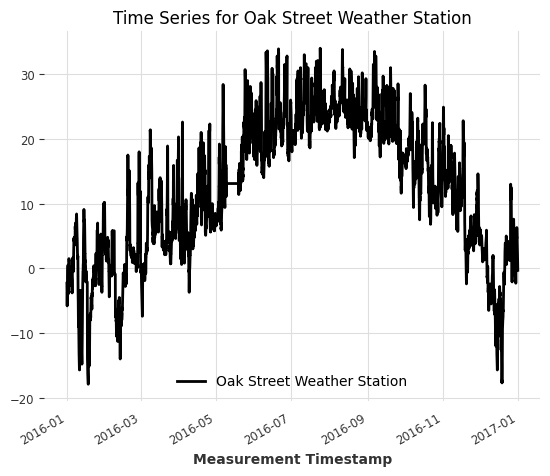

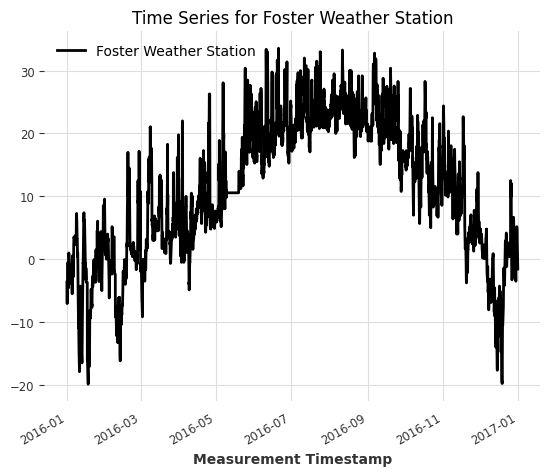

In [9]:
# Plot the time series for each station to visualize the data
for station, series in time_series_data.items():
    series.plot(label=station)
    plt.title(f'Time Series for {station}')
    plt.legend()
    plt.show()

In [21]:
# Perform the ADF test for stationarity and print the results
for station, series in time_series_data.items():
    # Convert the Darts TimeSeries to a pandas Series
    #series_pd = series.pd_series()
    
    # Perform ADF test
    adf_result = adfuller(series)
    print(f'Station: {station}')
    print(f'ADF Statistic: {adf_result[0]}')
    print(f'p-value: {adf_result[1]}')
    for key, value in adf_result[4].items():
        print(f'Critical Value ({key}): {value}')
    
    # Interpret the results
    if adf_result[1] < 0.01:
        print(f"The time series for {station} is likely stationary (p-value < 0.01).\n")
    else:
        print(f"The time series for {station} is likely non-stationary (p-value >= 0.01).\n")

# Calculate and print the correlation between each pair of stations
print("Correlation between time series:\n")
stations = list(time_series_data.keys())
for station1, station2 in combinations(stations, 2):
    # Convert both TimeSeries to pandas Series
    series1 = time_series_data[station1].series()
    series2 = time_series_data[station2].series()
    
    # Calculate Pearson correlation
    correlation = series1.corr(series2)
    print(f"Correlation between {station1} and {station2}: {correlation:.4f}")

    # Interpret the correlation strength
    if abs(correlation) > 0.8:
        print(f"High correlation between {station1} and {station2} (|correlation| > 0.8)\n")
    elif abs(correlation) > 0.5:
        print(f"Moderate correlation between {station1} and {station2} (|correlation| > 0.5)\n")
    else:
        print(f"Weak or no significant correlation between {station1} and {station2} (|correlation| <= 0.5)\n")


KeyboardInterrupt: 

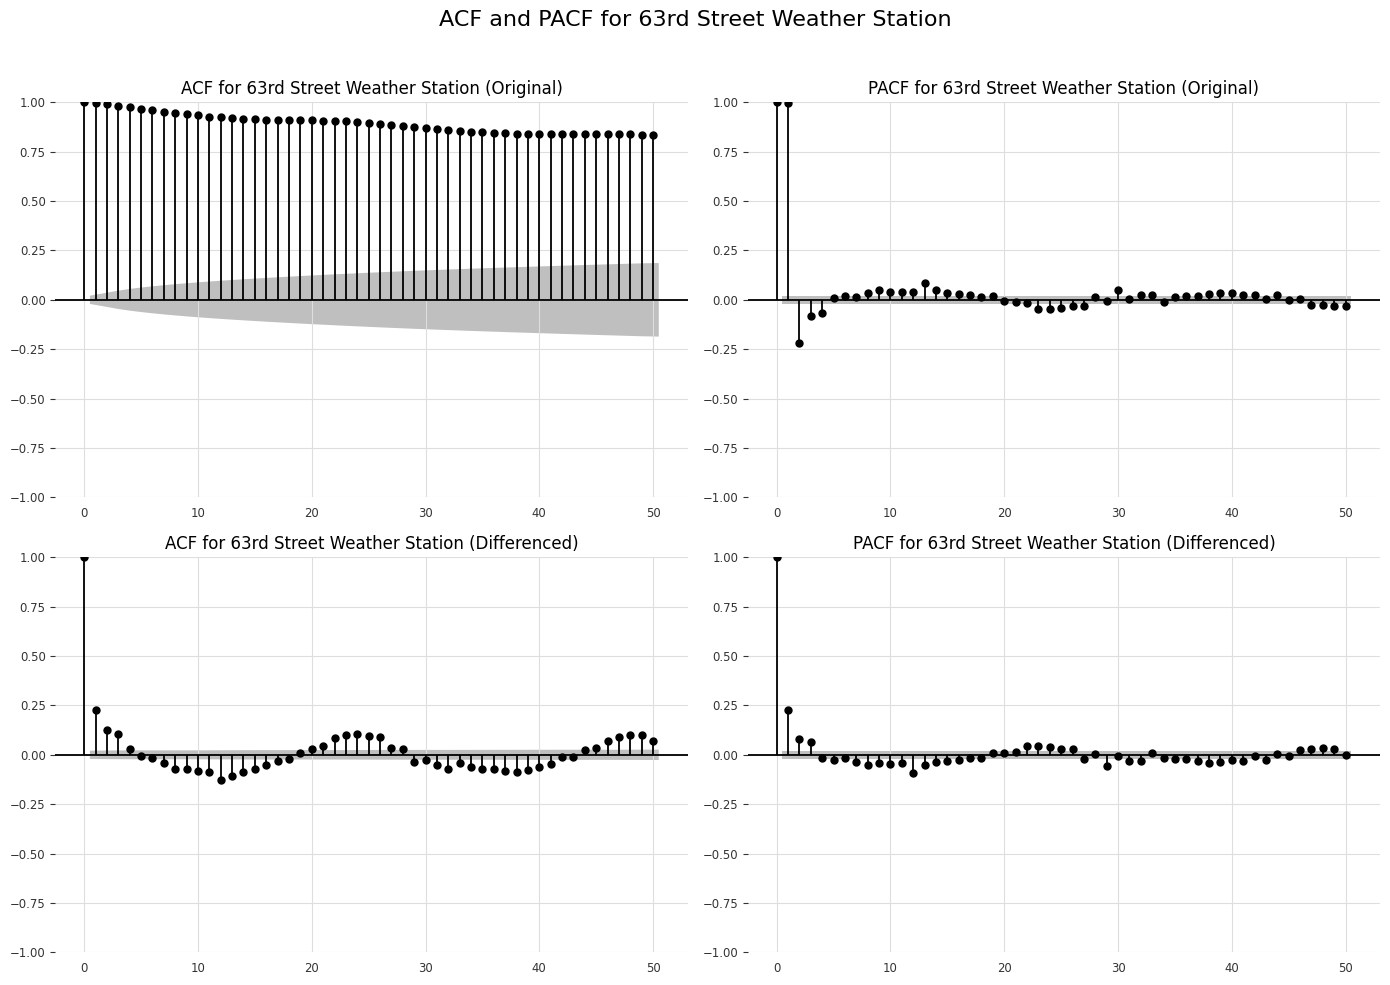

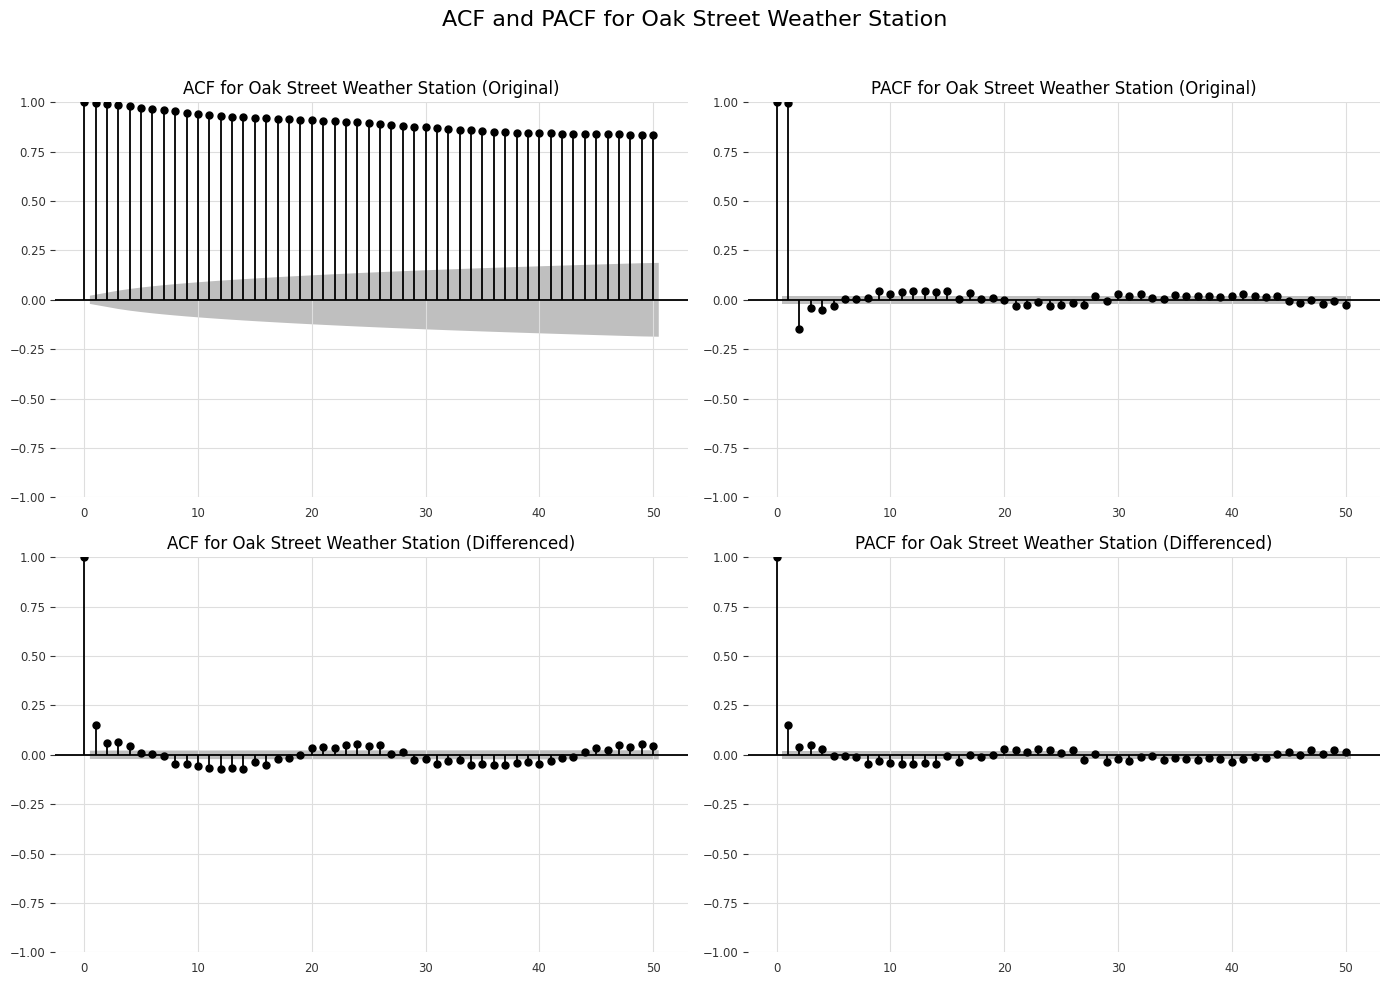

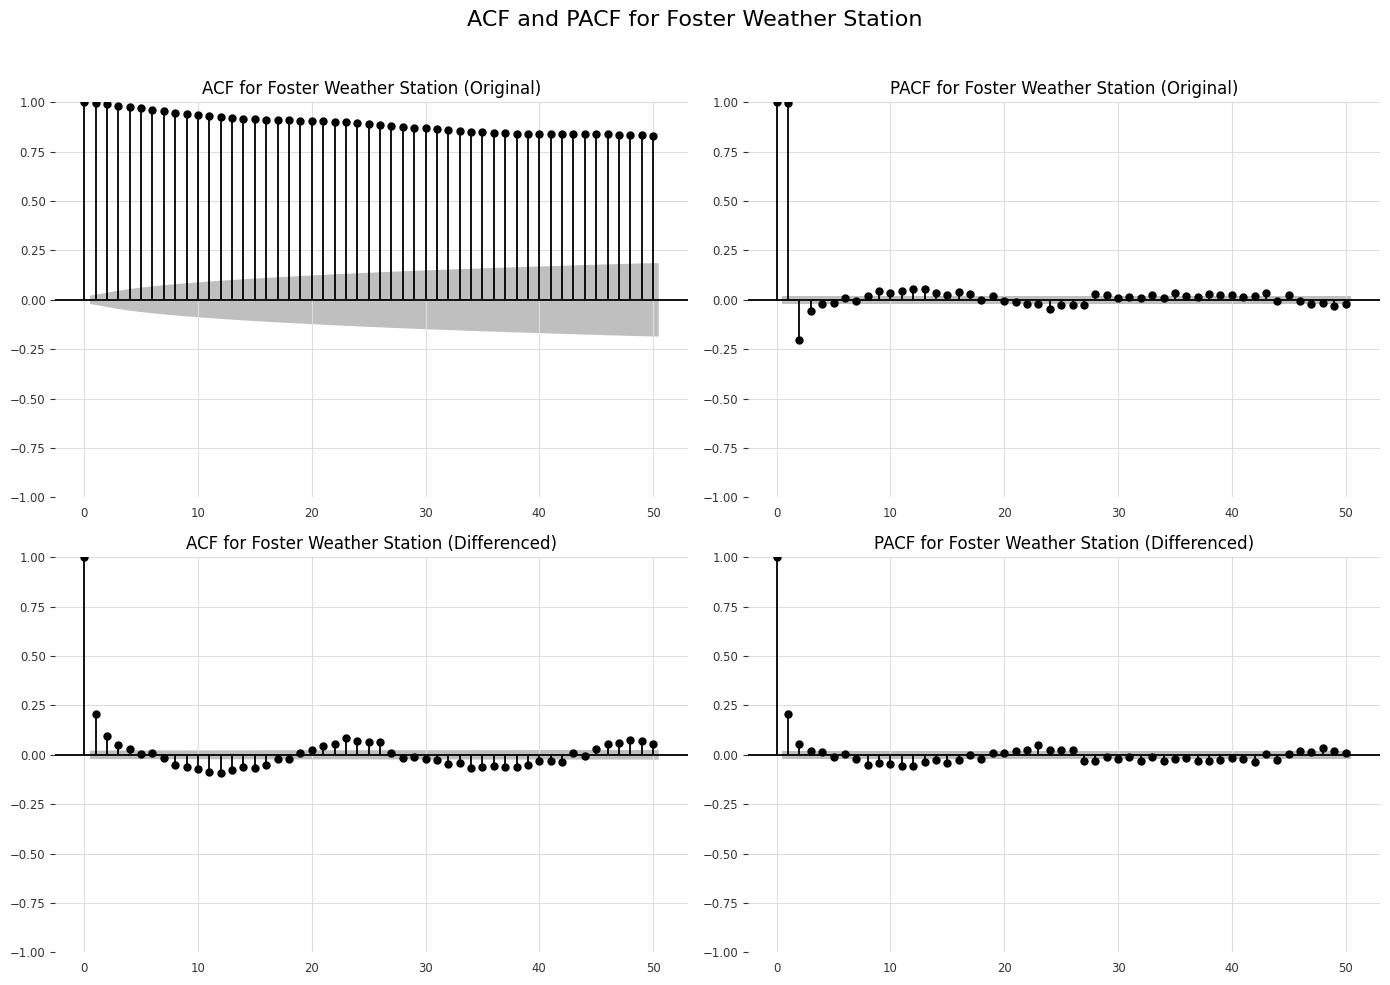

In [ ]:
# Generate ACF and PACF plots for each station
for station, series in time_series_data.items():
    # Convert Darts TimeSeries to pandas Series
    series_pd = series.pd_series()
    
    # First-order differencing
    diff_series_pd = series_pd.diff().dropna()
    
    # Create subplots for organized layout
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'ACF and PACF for {station}', fontsize=16)
    
    # Plot ACF for original series
    plot_acf(series_pd, lags=50, ax=axes[0, 0])
    axes[0, 0].set_title(f'ACF for {station} (Original)')
    
    # Plot PACF for original series
    plot_pacf(series_pd, lags=50, ax=axes[0, 1])
    axes[0, 1].set_title(f'PACF for {station} (Original)')
    
    # Plot ACF for first-differenced series
    plot_acf(diff_series_pd, lags=50, ax=axes[1, 0])
    axes[1, 0].set_title(f'ACF for {station} (Differenced)')
    
    # Plot PACF for first-differenced series
    plot_pacf(diff_series_pd, lags=50, ax=axes[1, 1])
    axes[1, 1].set_title(f'PACF for {station} (Differenced)')
    
    # Adjust layout and display the plots
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [ ]:

# Assuming `time_series_data` already contains the processed TimeSeries objects for each station

# Specify the target station for forecasting
target_station = '63rd Street Weather Station'
target_series = time_series_data[target_station]

# Combine all other stations as past covariates
past_covariates = TimeSeries.from_dataframe(
    pd.concat({station: ts.pd_series() for station, ts in time_series_data.items() if station != target_station}, axis=1)
)

# Ensure the past_covariates data includes late November to cover the full range needed
# Extending past_covariates to start earlier
extended_past_covariates = past_covariates.slice(pd.Timestamp('2016-11-01'), pd.Timestamp('2016-12-31 23:59:59'))

# Split data into training (up to end of November) and validation (December)
train_target = target_series.drop_after(pd.Timestamp('2016-11-30 23:59:59'))
val_target = target_series.slice(pd.Timestamp('2016-12-01'), pd.Timestamp('2016-12-31 23:59:59'))
train_past_covariates = extended_past_covariates.drop_after(pd.Timestamp('2016-11-30 23:59:59'))
val_past_covariates = extended_past_covariates.slice(pd.Timestamp('2016-12-01'), pd.Timestamp('2016-12-31 23:59:59'))

# Set up the Linear Regression Model
model = LinearRegressionModel(
    lags=24,                      # Use the past 24 hours of the target series
    lags_past_covariates=24,      # Use the past 24 hours of covariate series (other stations)
    output_chunk_length=24        # Predict the next 24 hours at once
)

# Fit the model using the training data
model.fit(series=train_target, past_covariates=train_past_covariates)

# Forecast for the length of the validation period (December)
forecast = model.predict(len(val_target), past_covariates=val_past_covariates)

# Calculate the MAE between the forecast and the actual December data
error = mae(val_target, forecast)
print(f"MAE for December forecast using Linear Regression Model: {error:.4f}")

# Plot the actual vs forecasted data
plt.figure(figsize=(12, 6))
val_target.plot(label="Actual")
forecast.plot(label="Forecast (Linear Regression)", color="orange")
plt.legend()
plt.title(f"Linear Regression Model Forecast for December - {target_station}")
plt.show()


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
ValueError: The `past_covariates` are not long enough. Given horizon `n=744`, `min(lags_past_covariates)=-24`, `max(lags_past_covariates)=-1` and `output_chunk_length=24`, the `past_covariates` have to range from 2016-11-30 00:00:00 until 2016-12-30 23:00:00 (inclusive), but they only range from 2016-12-01 00:00:00 until 2016-12-31 23:00:00.


ValueError: The `past_covariates` are not long enough. Given horizon `n=744`, `min(lags_past_covariates)=-24`, `max(lags_past_covariates)=-1` and `output_chunk_length=24`, the `past_covariates` have to range from 2016-11-30 00:00:00 until 2016-12-30 23:00:00 (inclusive), but they only range from 2016-12-01 00:00:00 until 2016-12-31 23:00:00.